# Compare Fits

In [1]:
# imports

from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from datetime import datetime, time
import random 
import torch

import pandas
import seaborn as sns

from oceancolor.utils import plotting 
from oceancolor.iop import cross

from ihop import io as ihop_io
from ihop.iops import decompose 
from ihop.emulators import io as emu_io
from ihop.inference import io as inf_io
from ihop.training_sets import load_rs

import reconstruct

In [2]:
%matplotlib ipympl

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/xavier/miniconda3/envs/os_11/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Load up

In [4]:
hidden_list=[512, 512, 512, 256]
dataset='L23' 
chop_burn=-3000 
abs_sig=None # Noiseless
perc=None
X=4 
Y=0 
in_idx:int=275
decomps=('nmf', 'nmf')
Ncomps = (4,2)

In [5]:
# Load
edict = emu_io.set_emulator_dict(dataset, decomps, Ncomps, 'Rrs',
    'dense', hidden_list=hidden_list, include_chl=True, X=X, Y=Y)

ab, Chl, Rs, d_a, d_bb = ihop_io.load_l23_full(decomps, Ncomps)

emulator, e_file = emu_io.load_emulator_from_dict(edict)

chain_file = inf_io.l23_chains_filename(edict, abs_sig) 
d_chains = inf_io.load_chains(chain_file)

Loading... 
Loading decomps from /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_a_N04.npz and /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_bb_N02.npz
Loading: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/L23/L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.pth
Loading MCMC chains: /home/xavier/Projects/Oceanography/Color/IHOP/Fits/L23/fitN_Rs01_L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.npz


In [6]:
emulator, e_file = emu_io.load_emulator_from_dict(edict)

Loading: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/L23/L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.pth


# Recover fitted coefficients

In [7]:
chains = d_chains['chains'][in_idx]
chains = chains[chop_burn:, :, :].reshape(-1, chains.shape[-1])

coeff_med = np.median(chains, axis=0)

In [8]:
coeff_med

array([1.0743458e-01, 6.8362378e-02, 7.6469176e-02, 7.2042070e-07,
       5.8094445e-03, 8.8892601e-02, 1.2937145e-01], dtype=float32)

# Reconstruct

## Best fit

In [9]:
reload(reconstruct)
items = reconstruct.one_spectrum(in_idx, ab, Chl, d_chains, 
                                     d_a, d_bb, 
                                     emulator, decomps[0], Ncomps)
idx, orig, a_mean, a_std, a_iop, obs_Rs,\
        pred_Rs, std_pred, NN_Rs, allY, wave,\
        orig_bb, bb_mean, bb_std, a_nmf, bb_nmf = items

Working on: L23 index=275


In [10]:
idx

275

# Compare

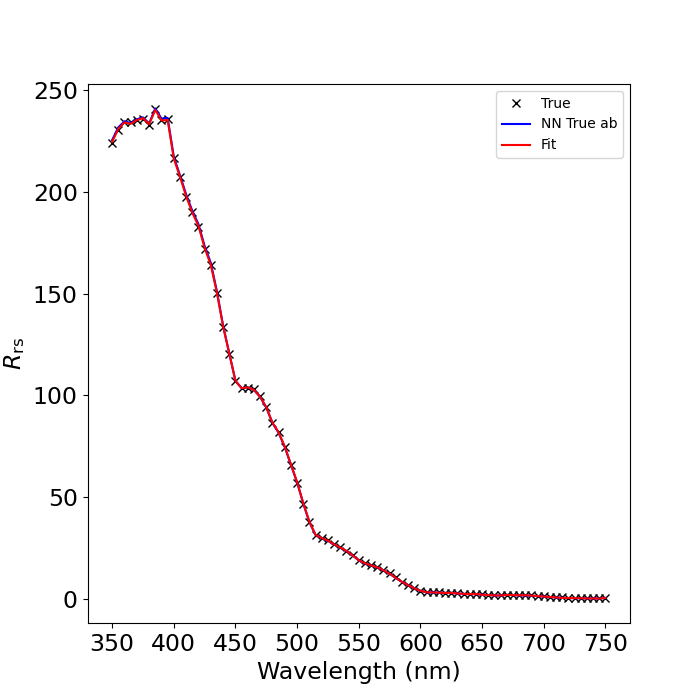

In [16]:
fig = plt.figure(figsize=(7,7))
ax_R = plt.gca()

ax_R.plot(wave, Rs[idx], 'kx', label='True')
ax_R.plot(wave, NN_Rs, 'b-', label='NN True ab')
#if true_only:
#    pass
#elif use_quick:
#    ax_R.plot(wave, obs_Rs[0], 'bs', label='"Observed"')
#else:
#    ax_R.plot(wave, obs_Rs[in_idx], 'bs', label='"Observed"')
ax_R.plot(wave, pred_Rs, 'r-', label='Fit', zorder=10)
#
ax_R.set_xlabel('Wavelength (nm)')
ax_R.set_ylabel(r'$R_{\rm rs}$')
#
ax_R.legend()
plotting.set_fontsize(ax_R, 17.)
plt.show()

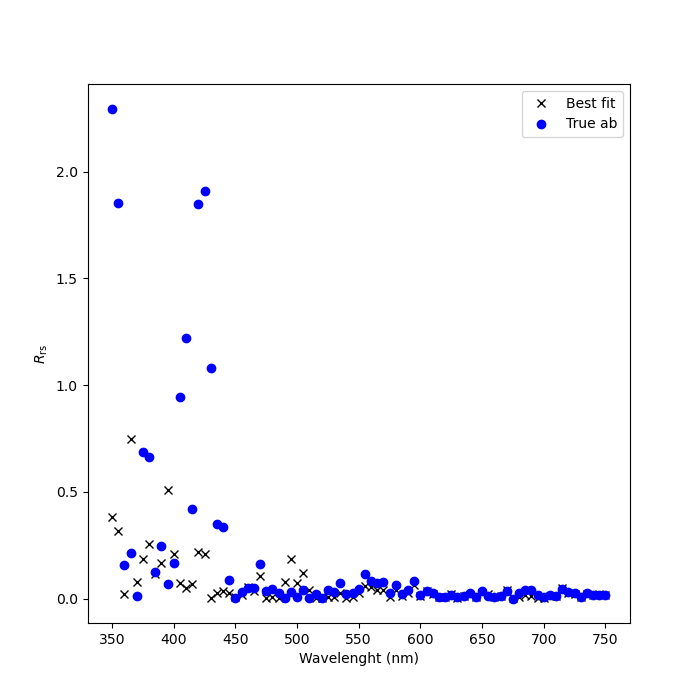

In [12]:
fig = plt.figure(figsize=(7,7))
ax_R = plt.gca()

#ax_R.plot(wave, (pred_Rs-Rs[idx])/Rs[idx], 'ko')
ax_R.plot(wave, (pred_Rs-Rs[idx])**2, 'ro', label='Best fit')
ax_R.plot(wave, (NN_Rs-Rs[idx])**2, 'kx', label='True ab')
#if true_only:
#    pass
#elif use_quick:
#    ax_R.plot(wave, obs_Rs[0], 'bs', label='"Observed"')
#else:
#    ax_R.plot(wave, obs_Rs[in_idx], 'bs', label='"Observed"')
ax_R.set_xlabel('Wavelength (nm)')
#ax_R.set_ylabel(r'$R_{\rm rs}$')
ax_R.legend()
plt.show()

# RMSE

In [93]:
rmse_best = np.sum((pred_Rs-Rs[idx])**2)
rmse_NN = np.sum((NN_Rs-Rs[idx])**2)
#
rmse_best, rmse_NN

(5.326911751782663, 16.615555)

# Changing one coefficient at a time

In [94]:
true_list = ab[idx].tolist() + [Chl[idx]]
true_list

[0.10942084471274881,
 0.08599627229726554,
 0.061382297197719864,
 3.973849960694717e-22,
 0.008552056358135574,
 0.08551623718986588,
 0.11438552]

In [95]:
coeff_med

array([1.0743458e-01, 6.8362378e-02, 7.6469176e-02, 7.2042070e-07,
       5.8094445e-03, 8.8892601e-02, 1.2937145e-01], dtype=float32)

## $H_2^a$

In [96]:
H2_list = true_list.copy()
H2_list[0] = coeff_med[0]
#
H3_list = true_list.copy()
H3_list[1] = coeff_med[1]
#
H4_list = true_list.copy()
H4_list[2] = coeff_med[2]
# 
H5_list = true_list.copy()
H5_list[3] = coeff_med[3]
# bb
bb2_list = true_list.copy()
bb2_list[4] = coeff_med[4]
# Chl
chl_list = true_list.copy()
chl_list[-1] = coeff_med[-1]

In [97]:
NN_Rs_H2 = emulator.prediction(H2_list, device)
NN_Rs_H3 = emulator.prediction(H3_list, device)
NN_Rs_H4 = emulator.prediction(H4_list, device)
NN_Rs_H5 = emulator.prediction(H5_list, device)
# bb
NN_Rs_bb2 = emulator.prediction(bb2_list, device)
# Chl
NN_Rs_chl = emulator.prediction(chl_list, device)

### Compare

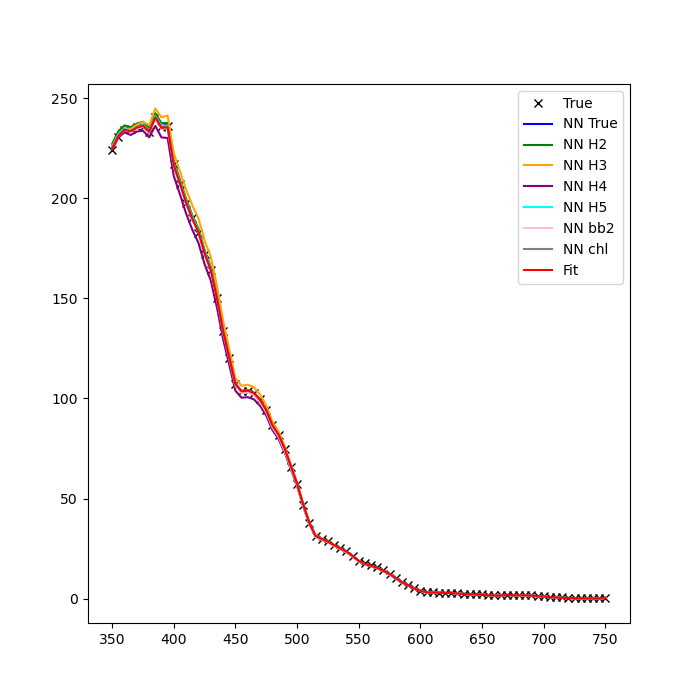

In [98]:
fig = plt.figure(figsize=(7,7))
ax_R = plt.gca()

ax_R.plot(wave, Rs[idx], 'kx', label='True')
ax_R.plot(wave, NN_Rs, 'b-', label='NN True')
ax_R.plot(wave, NN_Rs_H2, 'g-', label='NN H2')
ax_R.plot(wave, NN_Rs_H3, '-', color='orange', label='NN H3')
ax_R.plot(wave, NN_Rs_H4, '-', color='purple', label='NN H4')
ax_R.plot(wave, NN_Rs_H5, '-', color='cyan', label='NN H5')
#
ax_R.plot(wave, NN_Rs_bb2, '-', color='pink', label='NN bb2')
# Chl
ax_R.plot(wave, NN_Rs_chl, '-', color='gray', label='NN chl')
#if true_only:
#    pass
#elif use_quick:
#    ax_R.plot(wave, obs_Rs[0], 'bs', label='"Observed"')
#else:
#    ax_R.plot(wave, obs_Rs[in_idx], 'bs', label='"Observed"')
ax_R.plot(wave, pred_Rs, 'r-', label='Fit', zorder=10)
fill = False
if fill:
    ax_R.fill_between(wave, pred_Rs-std_pred, pred_Rs+std_pred, 
        color='r', alpha=0.5, zorder=10) 
    ax_R.fill_between(wave,
        pred_Rs-std_pred, pred_Rs+std_pred,
        color='r', alpha=0.5) 
#
ax_R.legend()
plt.show()

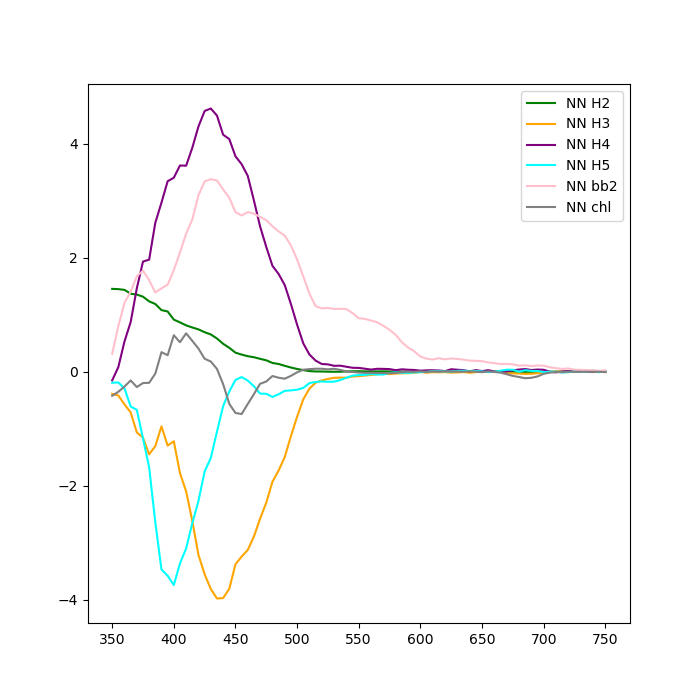

In [82]:
fig = plt.figure(figsize=(7,7))
ax_R = plt.gca()

#ax_R.plot(wave, Rs[idx], 'kx', label='True')
#ax_R.plot(wave, NN_Rs-Rs[idx], 'b-', label='NN True')
ax_R.plot(wave, NN_Rs_H2-NN_Rs, 'g-', label='NN H2')
ax_R.plot(wave, NN_Rs_H3-NN_Rs, '-', color='orange', label='NN H3')
ax_R.plot(wave, NN_Rs_H4-NN_Rs, '-', color='purple', label='NN H4')
ax_R.plot(wave, NN_Rs_H5-NN_Rs, '-', color='cyan', label='NN H5')
#
ax_R.plot(wave, NN_Rs_bb2-NN_Rs, '-', color='pink', label='NN bb2')
# Chl
ax_R.plot(wave, NN_Rs_chl-NN_Rs, '-', color='gray', label='NN chl')
#if true_only:
#    pass
#elif use_quick:
#    ax_R.plot(wave, obs_Rs[0], 'bs', label='"Observed"')
#else:
#    ax_R.plot(wave, obs_Rs[in_idx], 'bs', label='"Observed"')
#ax_R.plot(wave, pred_Rs, 'r-', label='Fit', zorder=10)
fill = False
if fill:
    ax_R.fill_between(wave, pred_Rs-std_pred, pred_Rs+std_pred, 
        color='r', alpha=0.5, zorder=10) 
    ax_R.fill_between(wave,
        pred_Rs-std_pred, pred_Rs+std_pred,
        color='r', alpha=0.5) 
#
ax_R.legend()
plt.show()

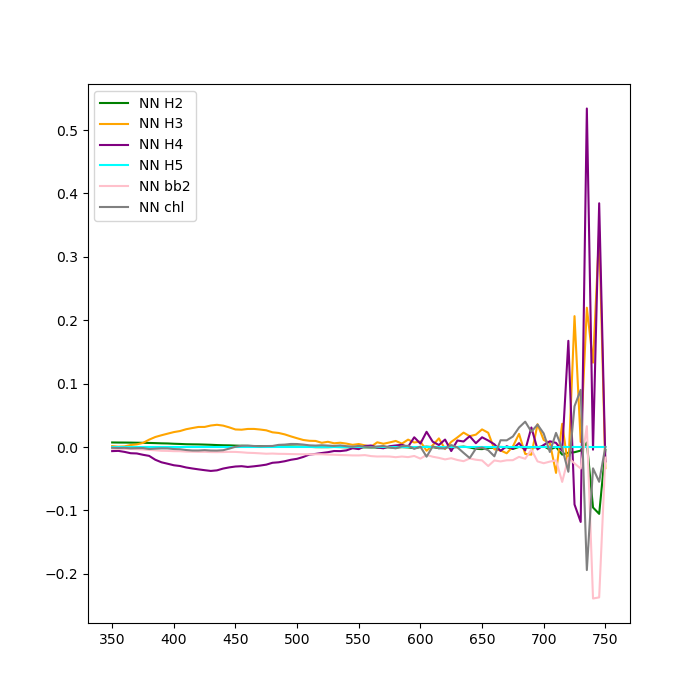

In [99]:
fig = plt.figure(figsize=(7,7))
ax_R = plt.gca()

#ax_R.plot(wave, Rs[idx], 'kx', label='True')
#ax_R.plot(wave, NN_Rs-Rs[idx], 'b-', label='NN True')
ax_R.plot(wave, (NN_Rs_H2-NN_Rs)/NN_Rs, 'g-', label='NN H2')
ax_R.plot(wave, (NN_Rs_H3-NN_Rs)/NN_Rs, '-', color='orange', label='NN H3')
ax_R.plot(wave, (NN_Rs_H4-NN_Rs)/NN_Rs, '-', color='purple', label='NN H4')
ax_R.plot(wave, (NN_Rs_H5-NN_Rs)/NN_Rs, '-', color='cyan', label='NN H5')
#
ax_R.plot(wave, (NN_Rs_bb2-NN_Rs)/NN_Rs, '-', color='pink', label='NN bb2')
# Chl
ax_R.plot(wave, (NN_Rs_chl-NN_Rs)/NN_Rs, '-', color='gray', label='NN chl')
#if true_only:
#    pass
#elif use_quick:
#    ax_R.plot(wave, obs_Rs[0], 'bs', label='"Observed"')
#else:
#    ax_R.plot(wave, obs_Rs[in_idx], 'bs', label='"Observed"')
#ax_R.plot(wave, pred_Rs, 'r-', label='Fit', zorder=10)
fill = False
if fill:
    ax_R.fill_between(wave, pred_Rs-std_pred, pred_Rs+std_pred, 
        color='r', alpha=0.5, zorder=10) 
    ax_R.fill_between(wave,
        pred_Rs-std_pred, pred_Rs+std_pred,
        color='r', alpha=0.5) 
#
ax_R.legend()
plt.show()